# KPrototypes

KMeans only works with numerical data. Since our dataset has a lot of categorical variables that we can exploit, we decided to try a variation of KMeans known as KPrototypes instead that offers support for both numerical and categorical data. 

KPrototypes is not available in `scikit-learn` but is available via the `kmodes` library.

**Setting up**

In [1]:
%load_ext kedro.ipython
%load_ext autoreload
%matplotlib inline
%autoreload 2

[04/16/23 13:12:23] INFO     Resolved project path as: /home/eckt/Documents/usg.                    ]8;id=776728;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=385086;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[04/16/23 13:12:25] INFO     Kedro project usg                                                      ]8;id=448441;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=492229;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=820213;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=717178;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

[04/16/23 13:12:26] INFO     Registered line magic 'run_viz'                                        ]8;id=140734;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=358209;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/ipython/__init__.py#110\110]8;;\

In [2]:
import pandas as pd
import polars as pl
import numpy as np

from matplotlib import rc_context
import matplotlib.pyplot as plt
import seaborn as sb
from seaborn.objects import Plot
import seaborn.objects as so

from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score

import logging

from usg.utils import *

log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
sb.set()

In [3]:
X = catalog.load('train')

[04/16/23 13:12:27] INFO     Loading data from 'train' (CSVDataSet)...                          ]8;id=304639;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=894803;file:///home/eckt/.local/share/virtualenvs/usg-8_lb1q9f/lib/python3.8/site-packages/kedro/io/data_catalog.py#343\343]8;;\

# Finding best number of clusters using elbow method

In [4]:
def cluster(n=1):
  model = KPrototypes(n_clusters = n, n_jobs = -1, random_state = 0)
  log.info("Performing clustering for n=%d", n)
  model.fit_predict(X=X[columns], categorical=list(range(0, len(categorical))))
  log.info("cost[%d]=%.2f", n, model.cost_)
  return model

In [5]:
cost = [cluster(i).cost_ for i in range(1, 26)]
cost

                    INFO     Performing clustering for n=1                                          ]8;id=383448;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=454311;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 13:12:40] INFO     cost[1]=2744.45                                                        ]8;id=162871;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=929561;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

                    INFO     Performing clustering for n=2                                          ]8;id=283799;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=398734;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 13:13:37] INFO     cost[2]=2261.80                                                        ]8;id=615272;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=991849;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

                    INFO     Performing clustering for n=3                                          ]8;id=732200;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=741986;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 13:15:05] INFO     cost[3]=1842.50                                                        ]8;id=885695;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=718911;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

                    INFO     Performing clustering for n=4                                          ]8;id=509993;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=831615;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 13:16:36] INFO     cost[4]=1539.01                                                        ]8;id=815914;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=420646;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

                    INFO     Performing clustering for n=5                                          ]8;id=950542;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=693876;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 13:18:46] INFO     cost[5]=1361.14                                                        ]8;id=86396;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=978999;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

                    INFO     Performing clustering for n=6                                          ]8;id=980887;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=946236;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 13:20:42] INFO     cost[6]=1197.39                                                        ]8;id=771558;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=805188;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

[04/16/23 13:20:43] INFO     Performing clustering for n=7                                          ]8;id=814099;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=229783;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 13:23:43] INFO     cost[7]=1108.33                                                        ]8;id=203215;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=44902;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

                    INFO     Performing clustering for n=8                                          ]8;id=361837;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=735287;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 13:27:38] INFO     cost[8]=1044.36                                                        ]8;id=162755;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=129760;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

                    INFO     Performing clustering for n=9                                          ]8;id=192603;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=273950;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 13:30:56] INFO     cost[9]=999.76                                                         ]8;id=439602;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=719011;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

                    INFO     Performing clustering for n=10                                         ]8;id=473254;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=663795;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 13:36:05] INFO     cost[10]=923.73                                                        ]8;id=579796;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=46203;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

                    INFO     Performing clustering for n=11                                         ]8;id=120077;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=168735;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 13:40:19] INFO     cost[11]=908.20                                                        ]8;id=342751;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=684049;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

                    INFO     Performing clustering for n=12                                         ]8;id=849272;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=313882;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 13:47:18] INFO     cost[12]=855.04                                                        ]8;id=634622;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=797267;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

                    INFO     Performing clustering for n=13                                         ]8;id=685068;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=507250;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 13:59:49] INFO     cost[13]=858.42                                                        ]8;id=70539;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=574429;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

                    INFO     Performing clustering for n=14                                         ]8;id=444092;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=716736;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 14:07:04] INFO     cost[14]=805.38                                                        ]8;id=343558;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=589703;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

                    INFO     Performing clustering for n=15                                         ]8;id=287153;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=928955;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 14:13:01] INFO     cost[15]=799.00                                                        ]8;id=485802;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=525570;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

                    INFO     Performing clustering for n=16                                         ]8;id=234563;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=784292;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 14:19:42] INFO     cost[16]=764.73                                                        ]8;id=157759;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=104189;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

                    INFO     Performing clustering for n=17                                         ]8;id=576337;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=532565;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 14:27:07] INFO     cost[17]=748.81                                                        ]8;id=870651;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=691149;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

                    INFO     Performing clustering for n=18                                         ]8;id=505519;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=742854;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 14:33:06] INFO     cost[18]=740.95                                                        ]8;id=290553;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=235480;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

                    INFO     Performing clustering for n=19                                         ]8;id=14595;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=518052;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 14:40:26] INFO     cost[19]=721.94                                                        ]8;id=784411;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=136722;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

                    INFO     Performing clustering for n=20                                         ]8;id=194670;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=676324;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 14:47:07] INFO     cost[20]=695.69                                                        ]8;id=891956;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=654295;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

                    INFO     Performing clustering for n=21                                         ]8;id=655663;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=207954;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 14:54:31] INFO     cost[21]=703.21                                                        ]8;id=10417;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=233766;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

                    INFO     Performing clustering for n=22                                         ]8;id=646689;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=646363;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 15:02:50] INFO     cost[22]=682.07                                                        ]8;id=759402;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=725099;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

                    INFO     Performing clustering for n=23                                         ]8;id=472901;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=593563;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 15:10:23] INFO     cost[23]=630.98                                                        ]8;id=594787;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=791206;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

                    INFO     Performing clustering for n=24                                         ]8;id=641507;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=202295;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 15:20:07] INFO     cost[24]=639.87                                                        ]8;id=939520;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=327704;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

                    INFO     Performing clustering for n=25                                         ]8;id=177189;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=415816;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 15:31:23] INFO     cost[25]=627.69                                                        ]8;id=521611;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=793500;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

[2744.4540146510717,
 2261.8041489321186,
 1842.504859712368,
 1539.0104997252351,
 1361.1386144987125,
 1197.3860007680905,
 1108.32946320978,
 1044.3630346804455,
 999.7610880604254,
 923.7271080732244,
 908.1986561846827,
 855.0379509075776,
 858.4150931480037,
 805.3795466650962,
 798.9968810298595,
 764.7317692869816,
 748.8148744828296,
 740.9471194389956,
 721.936423087211,
 695.6942414700434,
 703.2126661801738,
 682.0746967683117,
 630.9845652423388,
 639.8734490563482,
 627.6920977096283]

In [9]:
c_cost = [
    2744.4540146510717,
    2261.8041489321186,
    1842.504859712368,
    1539.0104997252351,
    1361.1386144987125,
    1197.3860007680905,
    1108.32946320978,
    1044.3630346804455,
    999.7610880604254,
    923.7271080732244,
    908.1986561846827,
    855.0379509075776,
    858.4150931480037,
    805.3795466650962,
    798.9968810298595,
    764.7317692869816,
    748.8148744828296,
    740.9471194389956,
    721.936423087211,
    695.6942414700434,
    703.2126661801738,
    682.0746967683117,
    630.9845652423388,
    639.8734490563482,
    627.6920977096283,
]

**n=4, n=6, n=8 are good candidates for optimal number of clusters**

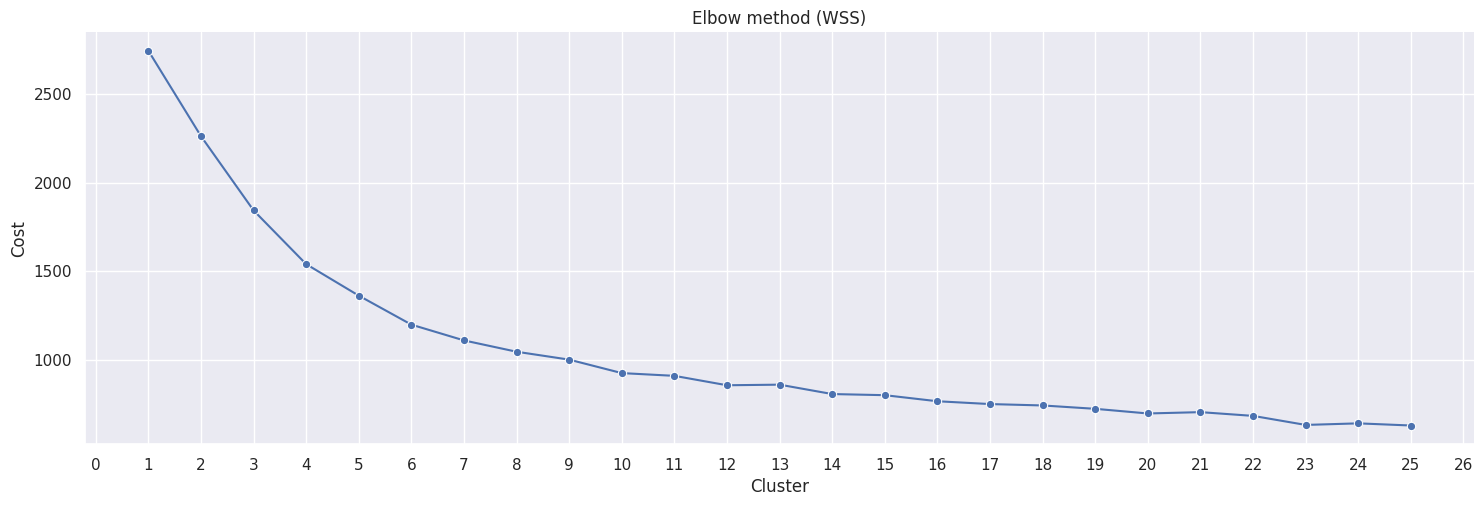

In [10]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame({'Cluster':list(range(1, len(c_cost)+1)), 'Cost':c_cost})
ax = sb.relplot(data=df_cost, x='Cluster', y='Cost', marker='o', kind='line', aspect=3).set(title='Elbow method (WSS)')
import matplotlib.ticker as ticker
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
ax

In [14]:
silhouette = [silhouette_score(X=X, labels=cluster(i).labels_) for i in [4,6,8,25]]
silhouette

[04/16/23 15:48:20] INFO     Performing clustering for n=4                                          ]8;id=73853;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=219378;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 15:50:12] INFO     cost[4]=1539.01                                                        ]8;id=90609;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=391188;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

[04/16/23 15:50:24] INFO     Performing clustering for n=6                                          ]8;id=93872;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=857639;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 15:52:37] INFO     cost[6]=1197.39                                                        ]8;id=337436;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=792042;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

[04/16/23 15:52:49] INFO     Performing clustering for n=8                                          ]8;id=751635;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=78331;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 15:57:36] INFO     cost[8]=1044.36                                                        ]8;id=977353;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=334891;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

[04/16/23 15:57:48] INFO     Performing clustering for n=25                                         ]8;id=64277;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=902340;file:///tmp/ipykernel_3088/1345073481.py#3\3]8;;\

[04/16/23 16:11:33] INFO     cost[25]=627.69                                                        ]8;id=35143;file:///tmp/ipykernel_3088/1345073481.py\1345073481.py]8;;\:]8;id=244100;file:///tmp/ipykernel_3088/1345073481.py#5\5]8;;\

[-0.11574996498691686,
 -0.13250156354411133,
 -0.16507944008579384,
 -0.38006571236901343]

# Summary

We select `n=4` because it has the best silhouette score. One reason for the low silhouette scores could be due to the fact that the statistics for steam games such as `positive_ratings`, `average_playtime`, `achievements` are not natural to games themselves. They could be influenced by variety of factors such as media coverage and country bans, etc.

Things that could be more organic would include `budget` allocated for the game, `development team size`, `duration of development` etc